<a href="https://colab.research.google.com/github/SimonDelgado/Procesamiento-Digital-Multimedia/blob/main/Proyecto%202/Proyecto_2_DelgadoSimon_202840051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Simón Delgado</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [30]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [31]:
import requests
import zipfile
import os

# URL archivo zip
url = "https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ/resolve/main/batch_june2024.zip"

# Ruta archivo zip
zip_path = "batch_june2024.zip"

# Ruta archivo descomprimido
extract_folder = "ImagenesParaProcesar"

# Descargar el archivo zip
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Crear la carpeta de destino si no existe
os.makedirs(extract_folder, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

print("Descarga y descompresión completadas.")

Descarga y descompresión completadas.


## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

Preprocesamiento de Imágenes Utilizando Binarización y Redimensionamiento

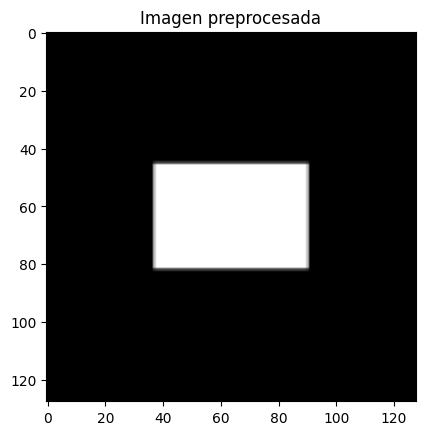

In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Función de preprocesamiento
def preprocess_image(image_path, size=(128, 128)):

    image = cv2.imread(image_path)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango para el color rojo en HSV
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])

    # Máscara para los píxeles rojos
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    # Se aplica la máscara a la imagen original
    red_objects = cv2.bitwise_and(image, image, mask=mask)

    # Convertir la imagen con objetos rojos a escala de grises
    gray_image = cv2.cvtColor(red_objects, cv2.COLOR_BGR2GRAY)

    # Binarización
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Redimensionamiento
    resized_image = cv2.resize(binary_image, size, interpolation=cv2.INTER_AREA)

    return resized_image

# Lista para almacenar las imágenes preprocesadas
preprocessed_images = []

# Ruta de la carpeta que contiene las imágenes
image_folder = '/content/ImagenesParaProcesar/processed512'

# Iterar sobre todas las imágenes en la carpeta
for image_filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_filename)
    if os.path.isfile(image_path):
        # preprocessed_image = preprocess_image(image_path)
        preprocessed_image = preprocess_image(image_path)
        preprocessed_images.append(preprocessed_image)

# Ejemplo de imagen preprocesada
if preprocessed_images:
    plt.imshow(preprocessed_images[0], cmap='gray')
    plt.title('Imagen preprocesada')
    plt.show()
else:
    print("No se encontraron imágenes para preprocesar.")


Verificación de Subida y Redimensionamiento de Templates. Este paso fue importante ya que la carga y el redimensionado de los Templates estaba arrojando error.

In [33]:
# Rutas a los archivos de template
template_paths = {
    'box': '/content/box_templae.png',
    'circle': '/content/circ_templae.png',
    'cross': '/content/cross_templae.png'
}

# Cargar y verificar cada template
templates = {}
for name, path in template_paths.items():
    if os.path.exists(path):
        template = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if template is None:
            print(f"Error: El template {name} no pudo ser cargado desde {path}.")
        else:
            print(f"Template {name} cargado correctamente.")

            try:
                resized_template = cv2.resize(template, (16, 16), interpolation=cv2.INTER_AREA)
                templates[name] = resized_template
                print(f"Template {name} redimensionado correctamente.")
            except Exception as e:
                print(f"Error al redimensionar el template {name}: {e}")
    else:
        print(f"Error: El archivo {name} no existe en la ruta especificada ({path}).")

Template box cargado correctamente.
Template box redimensionado correctamente.
Template circle cargado correctamente.
Template circle redimensionado correctamente.
Template cross cargado correctamente.
Template cross redimensionado correctamente.


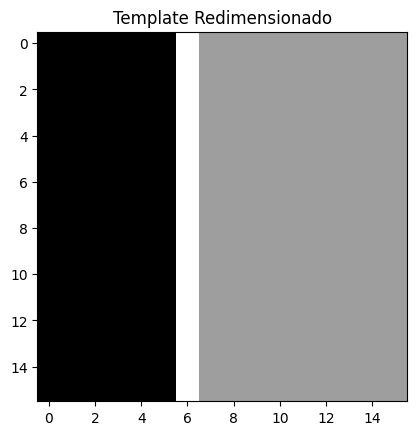

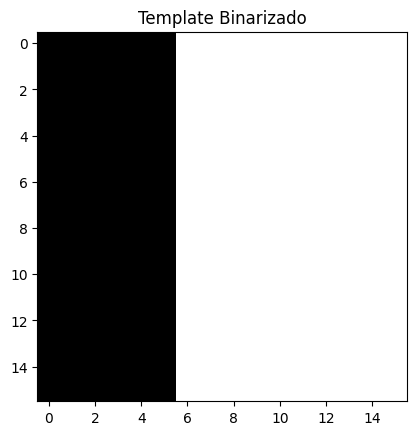

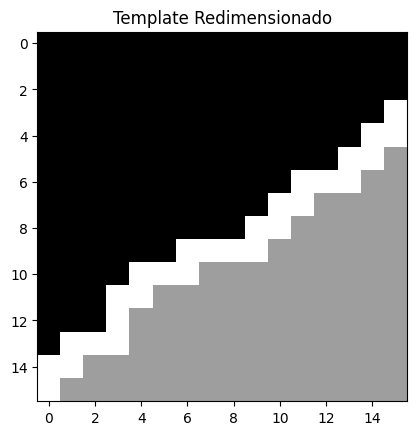

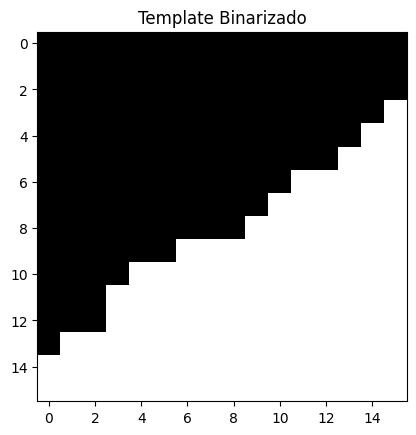

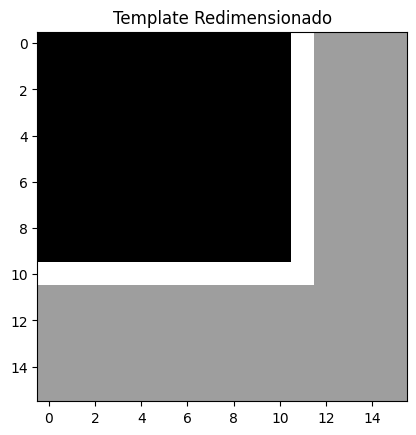

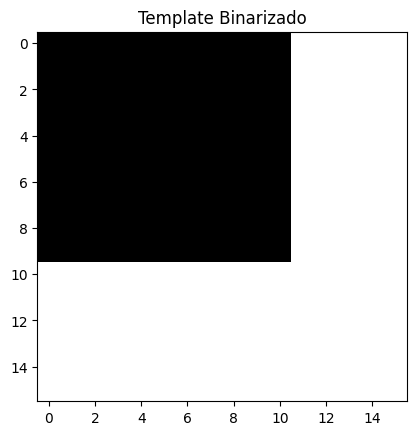

In [34]:
# Función para preprocesar los templates. Es diferente ya que el proceso de binarización y resizing de las imágenesno estaba funcionando para los templates.
def preprocess_template(template, size=(16, 16), visualize_steps=False):
    # Redimensionar el template
    resized_template = cv2.resize(template, size, interpolation=cv2.INTER_AREA)

    # Mostrar el template redimensionado en escala de grises
    if visualize_steps:
        plt.imshow(resized_template, cmap='gray')
        plt.title('Template Redimensionado')
        plt.show()

    # Binarización del template
    _, binary_template = cv2.threshold(resized_template, 50, 255, cv2.THRESH_BINARY)

    # Mostrar el template binarizado
    if visualize_steps:
        plt.imshow(binary_template, cmap='gray')
        plt.title('Template Binarizado')
        plt.show()

    return binary_template

# Diccionario para almacenar los templates preprocesados
preprocessed_templates = {}

# Preprocesar el template con visualización
for name, template in templates.items():
    if template is not None:
        preprocessed_templates[name] = preprocess_template(template, visualize_steps=True)
    else:
        print(f"El template {name} no está disponible para el preprocesamiento.")

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

<!-- ![image.png](attachment:6850d57c-7e6f-4acf-ac3b-d9a8feb071cb.png) -->

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [35]:
from timeit import default_timer as timer

start = timer()

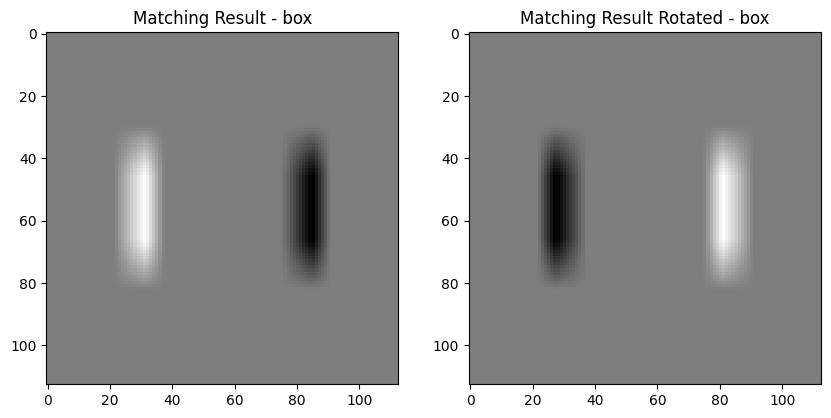

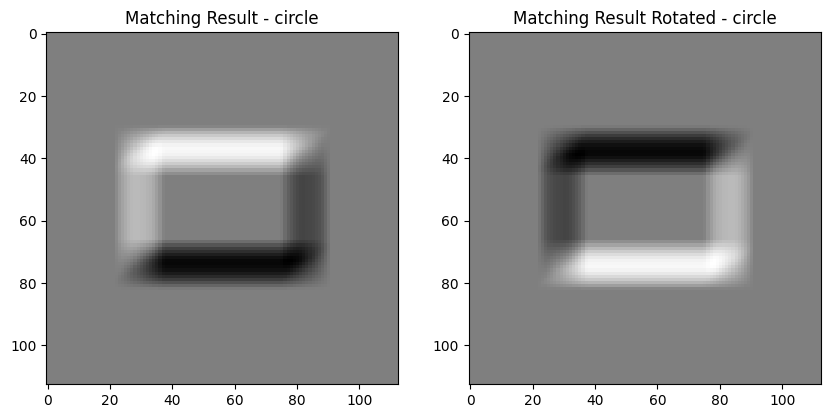

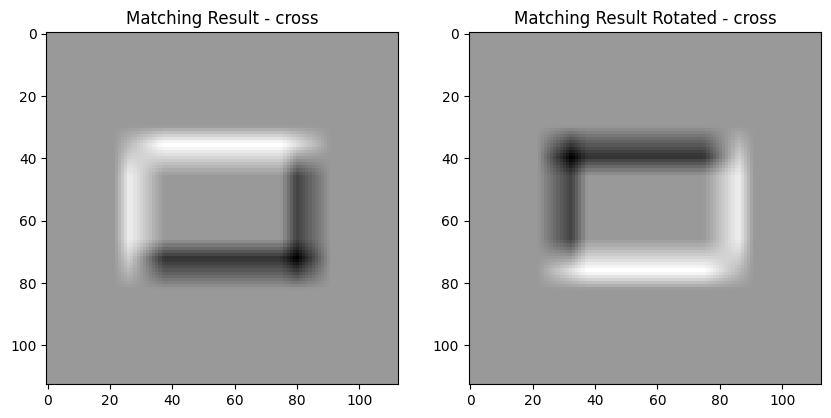

In [36]:
# Función para el matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF)

# Diccionario para almacenar los resultados del matching
matches = {name: [] for name in preprocessed_templates.keys()}

# Iterar sobre cada imagen preprocesada
for image in preprocessed_images:
    for name, template in preprocessed_templates.items():
        # Realizar el matching con el template
        match_result = match_template(image, template)
        matches[name].append(match_result)

        # Rotar el template 180 grados y realizar el matching nuevamente
        rotated_template = cv2.rotate(template, cv2.ROTATE_180)
        rotated_match_result = match_template(image, rotated_template)
        matches[name].append(rotated_match_result)

# Visualizar los resultados de matching para la primera imagen
if matches:
    for name, results in matches.items():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(results[0], cmap='gray')
        plt.title(f'Matching Result - {name}')

        plt.subplot(1, 2, 2)
        plt.imshow(results[1], cmap='gray')
        plt.title(f'Matching Result Rotated - {name}')

        plt.show()
else:
    print("No se encontraron resultados para mostrar.")

# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


In [37]:
# Función para obtener la máxima correlación del matching
def get_max_correlation(match_result):
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)
    return max_val

# Diccionario para almacenar las clasificaciones
classifications = []

# Iterar sobre cada conjunto de resultados de matching para cada imagen
for i in range(len(preprocessed_images)):
    # Diccionario para almacenar las máximas correlaciones
    max_correlations = {}

    for name in preprocessed_templates.keys():
        # Obtener el resultado de matching normal y rotado
        normal_match = matches[name][2*i]    # 2*i porque cada imagen tiene 2 resultados (normal y rotado)
        rotated_match = matches[name][2*i+1]

        # Extraer la máxima correlación
        max_corr_normal = get_max_correlation(normal_match)
        max_corr_rotated = get_max_correlation(rotated_match)

        # Tomar el máximo
        max_correlations[name] = max(max_corr_normal, max_corr_rotated)

    # Determinar la clasificación con la máxima correlación
    best_match = max(max_correlations, key=max_correlations.get)
    classifications.append(best_match)

# Mostrar las clasificaciones de las imágenes
for i, classification in enumerate(classifications):
    print(f"Imagen {i+1}: Clasificada como {classification}")

Se han truncado las últimas 5000 líneas del flujo de salida.
Imagen 9329: Clasificada como box
Imagen 9330: Clasificada como circle
Imagen 9331: Clasificada como cross
Imagen 9332: Clasificada como cross
Imagen 9333: Clasificada como cross
Imagen 9334: Clasificada como cross
Imagen 9335: Clasificada como box
Imagen 9336: Clasificada como box
Imagen 9337: Clasificada como cross
Imagen 9338: Clasificada como circle
Imagen 9339: Clasificada como box
Imagen 9340: Clasificada como box
Imagen 9341: Clasificada como circle
Imagen 9342: Clasificada como cross
Imagen 9343: Clasificada como cross
Imagen 9344: Clasificada como circle
Imagen 9345: Clasificada como circle
Imagen 9346: Clasificada como box
Imagen 9347: Clasificada como cross
Imagen 9348: Clasificada como box
Imagen 9349: Clasificada como cross
Imagen 9350: Clasificada como cross
Imagen 9351: Clasificada como box
Imagen 9352: Clasificada como circle
Imagen 9353: Clasificada como box
Imagen 9354: Clasificada como box
Imagen 9355: Clas

In [38]:
# Lista para almacenar las clasificaciones reales
real_classifications = []

# Extraer la clasificación real de cada nombre de archivo
for image_filename in os.listdir(image_folder):
    if "box" in image_filename:
        real_classifications.append("box")
    elif "cross" in image_filename:
        real_classifications.append("cross")
    elif "circ" in image_filename:
        real_classifications.append("circle")
    else:
        real_classifications.append("unknown")  # en caso de que no coincida con alguna categoría

# Mostrar las clasificaciones reales
for i, real_class in enumerate(real_classifications):
    print(f"Imagen {i+1}: Clasificación real es {real_class}")

Se han truncado las últimas 5000 líneas del flujo de salida.
Imagen 9329: Clasificación real es box
Imagen 9330: Clasificación real es circle
Imagen 9331: Clasificación real es cross
Imagen 9332: Clasificación real es cross
Imagen 9333: Clasificación real es cross
Imagen 9334: Clasificación real es cross
Imagen 9335: Clasificación real es cross
Imagen 9336: Clasificación real es cross
Imagen 9337: Clasificación real es cross
Imagen 9338: Clasificación real es circle
Imagen 9339: Clasificación real es box
Imagen 9340: Clasificación real es box
Imagen 9341: Clasificación real es circle
Imagen 9342: Clasificación real es cross
Imagen 9343: Clasificación real es cross
Imagen 9344: Clasificación real es circle
Imagen 9345: Clasificación real es circle
Imagen 9346: Clasificación real es cross
Imagen 9347: Clasificación real es cross
Imagen 9348: Clasificación real es box
Imagen 9349: Clasificación real es cross
Imagen 9350: Clasificación real es cross
Imagen 9351: Clasificación real es box
I

In [39]:
# Comparar clasificaciones predichas y reales
correct_matches = 0
for predicted, real in zip(classifications, real_classifications):
    if predicted == real:
        correct_matches += 1

accuracy = correct_matches / len(classifications) * 100
print(f"Exactitud de la clasificación: {accuracy:.2f}%")


Exactitud de la clasificación: 76.80%


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [40]:
end = timer()
print(end - start)

36.318097218000275
